# The Bias-Variance Tradeoff

Seja $y_{noisy}$ a função observável e $\hat{y}$ a função hipótese. Se o número de amostras, $N$, consideradas no cálculo do erro de predição para um **conjunto de exemplos inéditos tender ao infinito** e o ruído adicionado às amostras for branco (processo estocástico ergódico), então o erro pode ser aproximado como a esperança do erro quadrático e passa a ser chamado de **erro de generalização**: 

$$\text{MSE}_{N \to \infty} = \lim_{N \to \infty} \frac{1}{N} \sum_{n=0}^{N-1} (y_{noisy} - \hat{y})^2 
%
\\ = E[(y_{noisy} - \hat{y})^2].
$$

Lembrando que $y_{noisy} = y + w$, então
$$E[(y_{noisy} - \hat{y})^2] = E[(y + w - \hat{y})^2].$$

Expandindo a equação acima e agrupando alguns termos, temos

$$ E[ (y - \hat{y})^2 + 2 w (y - \hat{y}) + w^2  ].$$

Como $w$ é ruído branco Gaussiano, então $E[w] = 0$, e, desta forma, a equação acima pode ser simplificada para

$$E[ (y - \hat{y})^2 + w^2  ] \\= E[ (y - \hat{y})^2 ] + E[ w^2 ],$$

onde o primeiro termo é o **erro redutível** e o segundo termo o **erro irredutível**, aquele devido ao ruído e que não conseguimos diminuir.

Conseguimos expandir o primeiro termo e separar os termos referentes aos erros de **variância** e de **bias** deste estimador. 


Assumindo que os valores de $y$ não são aleatórios (i.e., determinísticos), podemos re-escrever o segundo termo como

$$E[ (y - \hat{y})^2 ] = y^2 -2 y E[\hat{y}] + E[\hat{y}^2].$$

O último termo da equação acima pode ser re-escrito como $E[\hat{y}^2] = \text{var}(\hat{y}) + E[\hat{y}]^2$, e, então, temos

$$E[ (y - \hat{y})^2 ] = (y - E[\hat{y}])^2 + (E[\hat{y}^2]-E[\hat{y}]^2) \\= \text{bias}(\hat{y})^2 + \text{var}(\hat{y}).$$

O primeiro termo da equação acima nos dá o valor do erro de **bias** ao quadrado, enquanto o segundo termo nos dá o erro de **variância** do estimador.

#### Portanto, podemos reescrever a equação da esperança do erro quadrático como

$$E[(y_{noisy} - \hat{y})^2] = \text{bias}(\hat{y})^2 + \text{var}(\hat{y}) + E[ w^2 ].$$

Os dois primeiros termos são sempre positivos (no mínimo iguais a zero) e, portanto, $E[(y_{noisy} - \hat{y})^2]$ nunca será igual a zero se $E[ w^2 ] \neq 0$. 

Se o ruído, $w$, tiver média igual a zero, então $E[ w^2 ]=\text{var}(w)$.

Também podemos ver que para minimizar o erro, devemos ter ambos os erros, **bias** e **variância**, com os menores valores possíveis. Portanto, para se ter um modelo que generalize bem, ambos valores devem ser pequenos.

+ **erro de generalização**: resultante da soma dos erros de bias, variância e irredutível.
    * Pode ser aproximado pelo **erro de validação**.
+ **erro de viés** (ou bias): parte do erro de generalização que diz, na média, quanto $\hat{y} \neq y$, ou seja, mede o erro entre a média da aproximação e a função verdadeira. É uma medida de quanto o modelo consegue capturar o comportamento da função verdadeira.
    * Um modelo tem um **bias** alto quando, por exemplo, não consegue capturar o comportamento do modelo gerador.
+ **erro de variância**: parte do erro de generalização que diz o quanto $\hat{y}$ é inconsistente (i.e., varia) através de diferentes conjuntos de treinamento. Mede a variação no desempenho do modelo quando ele se ajusta a diferentes conjuntos de treinamento.
    * Um modelo tem alta **variância** quando, por exemplo, ele treina tão bem que captura não apenas os padrões significativos, mas também o ruído presente nos dados.
+ **erro irredutível**: é o limite inferior do erro de generalização. É o erro causado por elementos fora do nosso controle, como ruído nas amostras.

O desafio para termos um **modelo ótimo** está em encontrar a **capacidade (ou flexibilidade) ideal** ou **ponto de balanço**: ponto onde os valores dos erros de **bias** e de **variância** são baixos.

<img src="../../figures/erros_aproximação_estimaçãov2.png" width="400" height="400">

+ Se aumentamos a flexibilidade do modelo, sua variância aumenta e seu viés diminui.
+ Se diminuímos a flexibilidade do modelo, sua variância diminui e seu viés aumenta.

In [1]:
# Import all the necessary libraries.
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
#!pip install mlxtend
from mlxtend.evaluate import bias_variance_decomp

In [2]:
# Reset the pseudo random number generator so that the results are reproducible.
seed = 1012019
np.random.seed(seed)

In [3]:
def genTargetFunction(N):
    # Attribute.
    x1 = np.linspace(-3, 3, N).reshape(N, 1)
    # Create target function.
    y = 1.0 + x1 + x1**2
    # Noise.
    w = np.random.randn(N, 1)
    # Noisy version of the target function.
    y_noisy = y + w
    return x1, y_noisy, y

In [4]:
# Number of examples.
N = 200

# Generate dataset.
x1, y_noisy, y = genTargetFunction(N)

# Split dataset.
X_train, X_test, y_train, y_test = train_test_split(x1, y_noisy, test_size=0.5, random_state=seed)

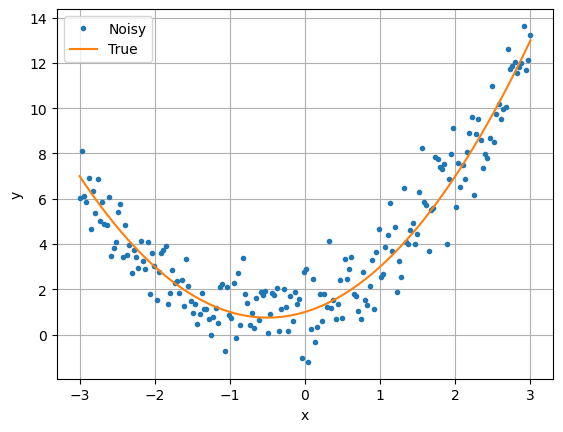

In [5]:
plt.figure()
plt.plot(x1,y_noisy,'.', label='Noisy')
plt.plot(x1,y,label='True')
plt.grid()
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [6]:
# Polinomial degrees to be tested.
degrees = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

# Empty arrays.
mse = np.zeros((len(degrees),))
var = np.zeros((len(degrees),))
bias = np.zeros((len(degrees),))

# Iterate over different polynomial degrees.
for i in range(len(degrees)):
    
        # Instantiate a polynomial with the given degree.
        poly = PolynomialFeatures(degree=degrees[i])
        # Instantiate a scaler that will standardize the features.
        scaler = StandardScaler()
        # Instantiate a linear regressor.
        reg = LinearRegression()

        # Create a pipeline of actions.
        model = Pipeline([
            ("poly", poly),
            ("scaler", scaler),
            ("reg", reg),
        ])
        
        # estimate bias and variance
        mse[i], bias[i], var[i] = bias_variance_decomp(model, X_train, y_train.ravel(), X_test, y_test.ravel(), loss='mse', num_rounds=300, random_seed=seed)        

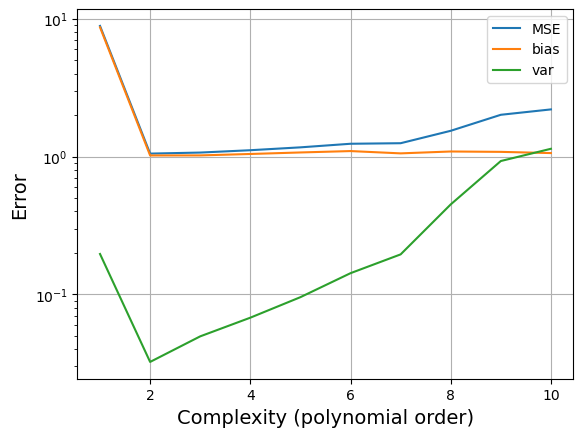

In [7]:
fig = plt.figure()

plt.plot(degrees, mse, label='MSE')
plt.plot(degrees, bias, label='bias')
plt.plot(degrees, var, label='var')
plt.yscale('log')
plt.legend()
plt.xlabel('Complexity (polynomial order)', fontsize=14)
plt.ylabel('Error', fontsize=14)
plt.grid()

if(0):
    left, bottom, width, height = [0.3, 0.55, 0.4, 0.3]
    ax3 = fig.add_axes([left, bottom, width, height])
    plt.plot(degrees, mse, label='MSE')
    plt.plot(degrees, bias, label='bias')
    plt.plot(degrees, var, label='var')
    ax3.set_ylim(-0.5, 2)
    ax3.set_xlim(1, 10)

plt.show()

### Referências

[1] https://dustinstansbury.github.io/theclevermachine/bias-variance-tradeoff